In [1]:
import copy
import pathlib
import os
import os.path
from typing import Sequence
import itertools

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
import warnings # To suppress some warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## Control: Obs: Concat(Ref State, $\Delta$ Ref State)

In [5]:
def load_data(paths: Sequence[str]):
    dfs = []
    for path in paths:
        with tf.io.gfile.GFile(path, "r") as readable:
            dfs.append(pd.read_json(readable, orient="records", lines=True))
    return pd.concat(dfs)

In [6]:
df_result = load_data(
    tf.io.gfile.glob(os.path.join(pathlib.Path.home(), "fs/drmdp/exp/rewest/1745404452/*.jsonl"))
)

In [7]:
df_result

,task_id,env_name,env_args,control_feats_spec,rewest_sample_size,least_feats_spec,reward_delay,num_episodes,use_bias,epochs,turn,meta
0,cf12ee61-61d6-4c95-81fd-e30df730a3d8,RedGreen-v0,None,"{'name': 'tiles', 'args': {'tiling_dim': 6}}",800,"{'name': 'tiles', 'args': {'tiling_dim': 6}}",4,1000,True,100,3,"{'use_bias': True, 'sample': {'size': 800}, 'e..."
1,68263447-b797-4017-bfe1-3a462d34516b,Finite-TC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'scale', 'args': None}",8000,"{'name': 'scale', 'args': None}",6,1000,False,1,1,"{'use_bias': False, 'sample': {'size': 8000}, ..."
2,e7e56b01-45f0-46f0-827a-5f4bb3d4bc5f,Finite-SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'spliced-tiles', 'args': {'tiling_dim...",8000,"{'name': 'scale', 'args': None}",6,1000,False,1,0,"{'use_bias': False, 'sample': {'size': 8000}, ..."
3,8c39e84f-2fc6-4b0d-af01-6d3ebef50426,Finite-SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'scale', 'args': None}",8000,"{'name': 'scale', 'args': None}",6,1000,False,1,1,"{'use_bias': False, 'sample': {'size': 8000}, ..."
4,8b64f549-3b5b-4397-a1b8-b138dacaa29f,Finite-SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'scale', 'args': None}",8000,"{'name': 'scale', 'args': None}",6,1000,True,1,1,"{'use_bias': True, 'sample': {'size': 8000}, '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1af403d5-1522-4c78-ba88-accf67e7d96f,GridWorld-v0,{'max_episode_steps': 2500},"{'name': 'tiles', 'args': {'tiling_dim': 8}}",8000,"{'name': 'tiles', 'args': {'tiling_dim': 8}}",4,1000,True,10,3,"{'use_bias': True, 'sample': {'size': 8000}, '..."
96,e5c8b525-4f40-4466-ba8f-dcf8bb7bf289,Finite-TC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'tiles', 'args': {'tiling_dim': 3}}",64000,"{'name': 'scale', 'args': None}",4,1000,False,1,0,"{'use_bias': False, 'sample': {'size': 64000},..."
97,533800ce-8ddf-4940-95b8-60d6b2fc1502,MountainCar-v0,{'max_episode_steps': 2000},"{'name': 'tiles', 'args': {'tiling_dim': 6}}",1000,"{'name': 'tiles', 'args': {'tiling_dim': 6}}",4,1000,True,10,4,"{'use_bias': True, 'sample': {'size': 1000}, '..."
98,3b8776b8-f2ac-4ac9-bbf3-ea89917ca0b9,Finite-TC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...","{'name': 'tiles', 'args': {'tiling_dim': 3}}",32000,"{'name': 'scale', 'args': None}",4,1000,True,1,3,"{'use_bias': True, 'sample': {'size': 32000}, ..."


In [8]:
def process_results(df_input):
    # averane at each poit in time
    def tfx_method(feats_spec):
        name = feats_spec["name"]
        if feats_spec["args"] is not None:
            kwargs = feats_spec["args"]
            # first char, value
            values = [f"{key[0]}:{str(value)}" for key, value in sorted(kwargs.items())]
            suffix = "/".join(values)
        else:
            suffix = "-"
        return f"{name}({suffix})"

    def control_type(name: str):
        if "-TC-" in name:
            return "Torque"
        elif "-CC-" in name:
            return "Current"
        elif "-SC-" in name:
            return "Speed"
        return "Classic"

    def bias(meta):
        return "Yes" if meta["use_bias"] else "No"

    def rmse(meta):
        error = meta.get("error", {"rmse": np.nan})
        return error["rmse"]

    def rename(env):
        return env.lstrip("Finite-")

    df_out = copy.deepcopy(df_input)
    df_out["least_feats_spec"] = df_out["least_feats_spec"].apply(tfx_method)
    df_out["control_feats_spec"] = df_out["control_feats_spec"].apply(tfx_method)
    df_out["control_type"] = df_out["env_name"].apply(control_type)
    df_out["env_name"] = df_out["env_name"].apply(rename)
    df_out["bias"] = df_out["meta"].apply(bias)
    df_out["rmse"] = df_out["meta"].apply(rmse)
    df_out = df_out.drop(["meta"], axis=1)
    return df_out[~pd.isna(df_out["rmse"])], df_out[pd.isna(df_out["rmse"])]

In [9]:
df_proc_result, df_no_est = process_results(df_result)

In [10]:
df_no_est

,task_id,env_name,env_args,control_feats_spec,rewest_sample_size,least_feats_spec,reward_delay,num_episodes,use_bias,epochs,turn,control_type,bias,rmse
16,1911138a-05c5-4875-b5df-cf4534b031c9,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,False,1,2,Speed,No,NaN
44,f378ff31-73bc-4a67-84ef-d524e4b2c00f,TC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),64000,scale(-),6,1000,True,1,3,Torque,Yes,NaN
99,43d354b7-b520-48c7-8785-eef711b2e12d,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,True,1,4,Speed,Yes,NaN
73,140ac662-42dd-499f-a914-7c4c7a38ddd5,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,False,1,4,Speed,No,NaN
64,e2d9720e-8c04-4b7d-aa6b-8ea9a66b5f10,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,True,1,3,Speed,Yes,NaN
78,ce6f90bf-3128-437e-9d63-4a4cd8a16008,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,False,1,0,Speed,No,NaN
77,80c2faa0-b198-41ff-9525-8f43340ee805,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,False,1,1,Speed,No,NaN
87,d0718809-820e-4679-a4b5-d65117625c0b,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,False,1,3,Speed,No,NaN
48,6fd22cb8-ed70-4c16-ba4a-d7ad93f86342,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,True,1,2,Speed,Yes,NaN
1,df89e253-c1e6-4e32-a30e-afa770fc4bbf,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),64000,scale(-),6,1000,True,1,0,Speed,Yes,NaN


In [11]:
df_proc_result

,task_id,env_name,env_args,control_feats_spec,rewest_sample_size,least_feats_spec,reward_delay,num_episodes,use_bias,epochs,turn,control_type,bias,rmse
0,cf12ee61-61d6-4c95-81fd-e30df730a3d8,RedGreen-v0,None,tiles(t:6),800,tiles(t:6),4,1000,True,100,3,Classic,Yes,5.794492e-15
1,68263447-b797-4017-bfe1-3a462d34516b,TC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),8000,scale(-),6,1000,False,1,1,Torque,No,9.084246e-15
2,e7e56b01-45f0-46f0-827a-5f4bb3d4bc5f,SC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:3),8000,scale(-),6,1000,False,1,0,Speed,No,8.117314e-15
3,8c39e84f-2fc6-4b0d-af01-6d3ebef50426,SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),8000,scale(-),6,1000,False,1,1,Speed,No,9.692416e-14
4,8b64f549-3b5b-4397-a1b8-b138dacaa29f,SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),8000,scale(-),6,1000,True,1,1,Speed,Yes,8.949741e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1af403d5-1522-4c78-ba88-accf67e7d96f,GridWorld-v0,{'max_episode_steps': 2500},tiles(t:8),8000,tiles(t:8),4,1000,True,10,3,Classic,Yes,7.904410e-14
96,e5c8b525-4f40-4466-ba8f-dcf8bb7bf289,TC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",tiles(t:3),64000,scale(-),4,1000,False,1,0,Torque,No,3.896940e-15
97,533800ce-8ddf-4940-95b8-60d6b2fc1502,MountainCar-v0,{'max_episode_steps': 2000},tiles(t:6),1000,tiles(t:6),4,1000,True,10,4,Classic,Yes,3.790582e-15
98,3b8776b8-f2ac-4ac9-bbf3-ea89917ca0b9,TC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",tiles(t:3),32000,scale(-),4,1000,True,1,3,Torque,Yes,1.019502e-14


In [12]:
df_proc_result["control_type"].unique()

array(['Classic', 'Torque', 'Speed', 'Current'], dtype=object)

In [13]:
def export_figure(
    figure, name: str, format: str = "pdf", dpi=300, transparent: bool = True
):
    # to be able to save, we must plot
    base_dir = os.path.dirname(name)
    if not os.path.exists(base_dir):
        tf.io.gfile.makedirs(base_dir)
    
    figure.savefig(f"{name}.{format}", dpi=dpi, format=format, transparent=transparent)

In [14]:
def plot_sample_vs_error(df_input, control_type):
    df_slice = df_input[df_input["control_type"] == control_type]
    envs = sorted(df_slice["env_name"].unique())
    reward_delays = sorted(df_slice["reward_delay"].unique())
    envs_delays = tuple(itertools.product(envs, reward_delays))
    nrows = len(envs)
    ncols = len(reward_delays)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharey=True, sharex=False)
    hue_order = sorted(df_slice["use_bias"].unique())

    for (env, delay), ax in zip(envs_delays, axes.flatten()):
        df_plot = df_slice[
            (df_slice["env_name"] == env) &
            (df_slice["reward_delay"] == delay)
        ]        
        sns.lineplot(data=df_plot, x="rewest_sample_size", y="rmse", hue="use_bias", hue_order=hue_order, ax=ax)
        ax.set_title(f"Env={env}; Delay={delay}")
        ax.set_ylabel("$\hat{R}$ RMSE")
        ax.set_xlabel("Sample Size")
    fig.tight_layout()
    export_figure(
        fig, name=os.path.join(f"figures/re_least_error/{control_type}"),
    )
    

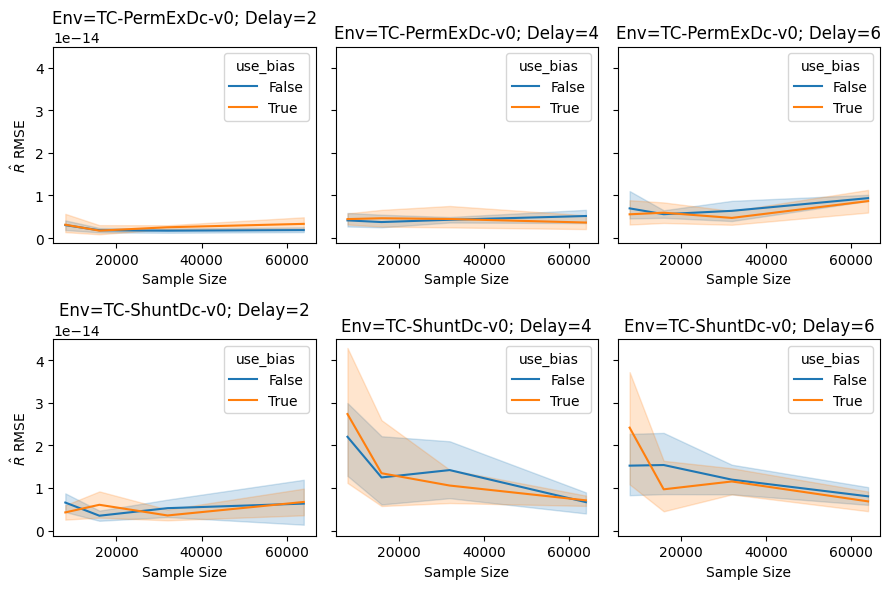

In [15]:
plot_sample_vs_error(df_proc_result, "Torque")

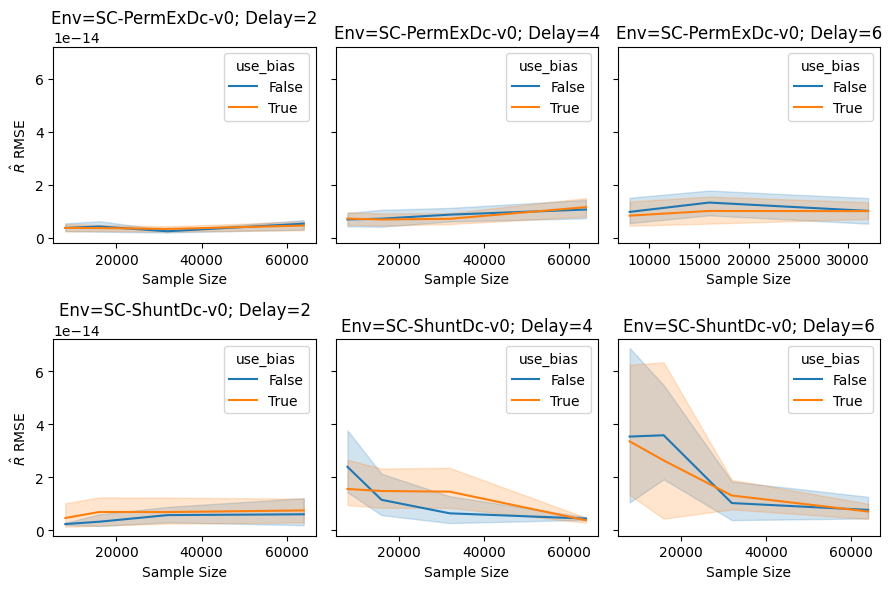

In [16]:
plot_sample_vs_error(df_proc_result, "Speed")

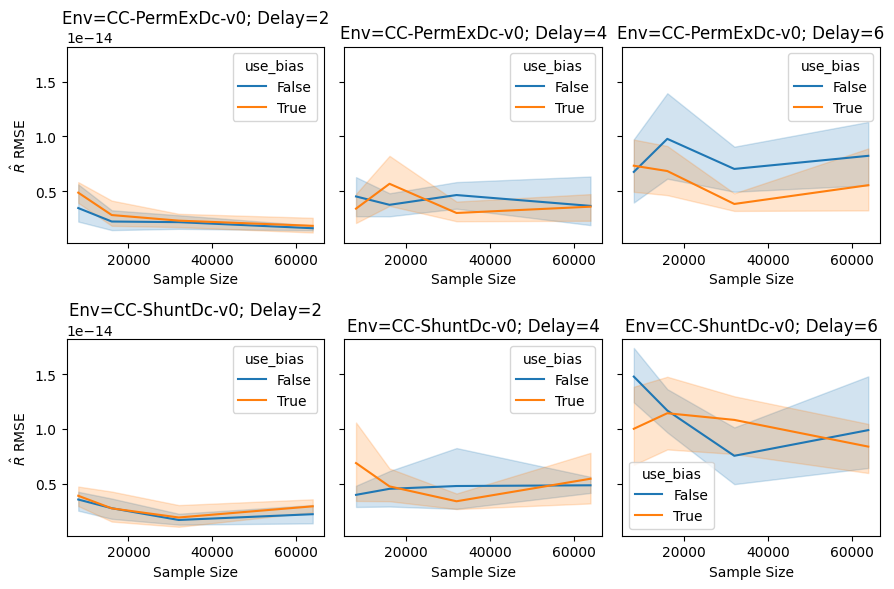

In [17]:
plot_sample_vs_error(df_proc_result, "Current")

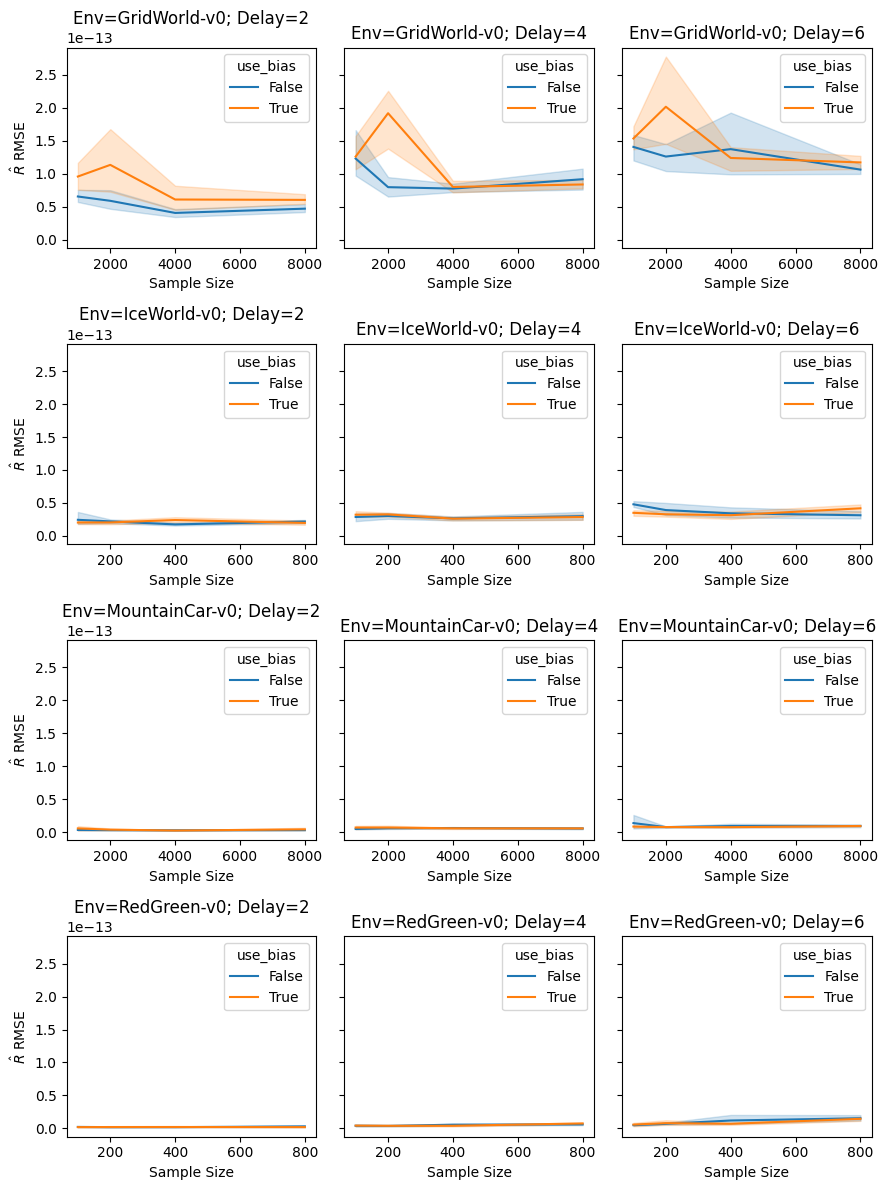

In [18]:
plot_sample_vs_error(df_proc_result, "Classic")